In [190]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import librosa
import librosa.display


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Any results you write to the current directory are saved as output.

# 1. Importando os Arquivos de Áudio

* audio1 - beethoven 5th symphony
* audio2 - Public Enemy - 911 is a Joke

(2, 661504)
[0.         0.         0.         ... 0.00299158 0.00720552 0.01044751]


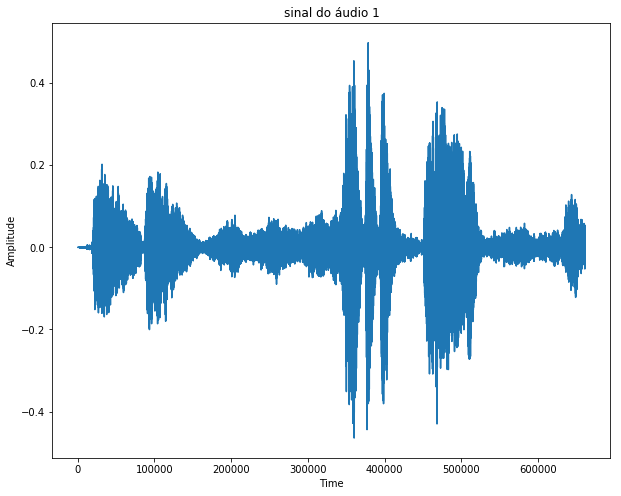

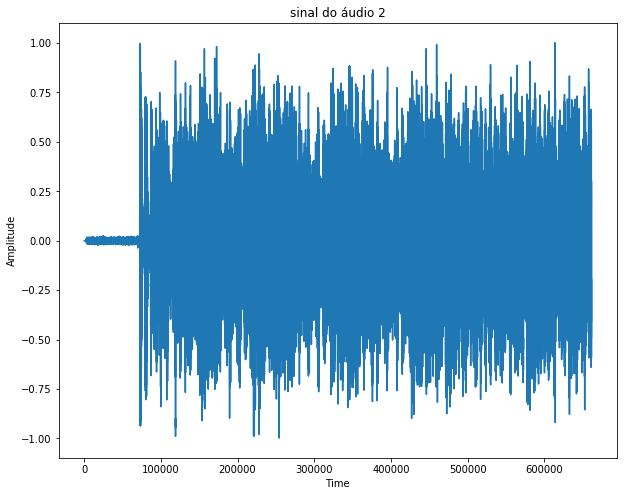

In [242]:
def import_signal(path):
    s, sr = librosa.core.load(path)
    return s

def plot_signals(s, index):
    fig, a = plt.subplots(1, figsize = (10, 8))
    title = "sinal do áudio {}".format(index+1)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(title)
    a.plot(s)


paths = ['/kaggle/input/audios/audio1.wav', '/kaggle/input/audios/audio2.wav']
signals = []
for p in paths:
    signals.append(import_signal(p))
signals = np.asarray(signals)
print(signals.shape)

for index, s in enumerate(signals):
    plot_signals(s, index)
    
print(signals[0])



# 2. Transformada de Fourier de Curto Termo

**hop_length** : int > 0 [scalar] - Usamos 1024

    number of audio samples between adjacent STFT columns.

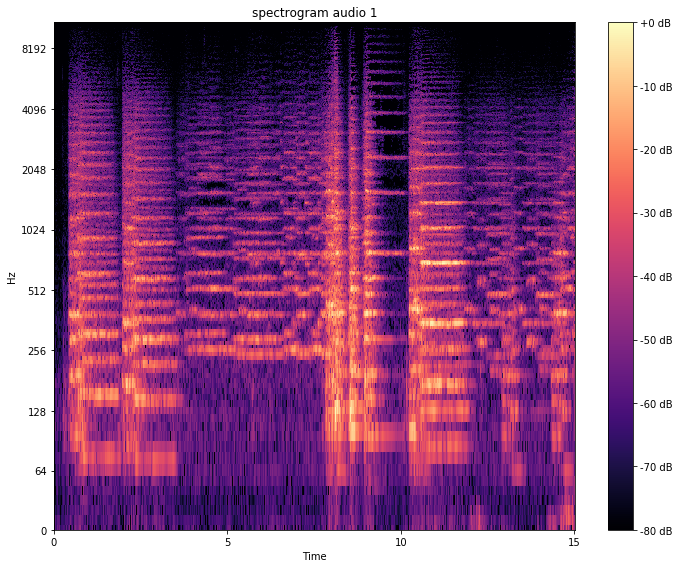

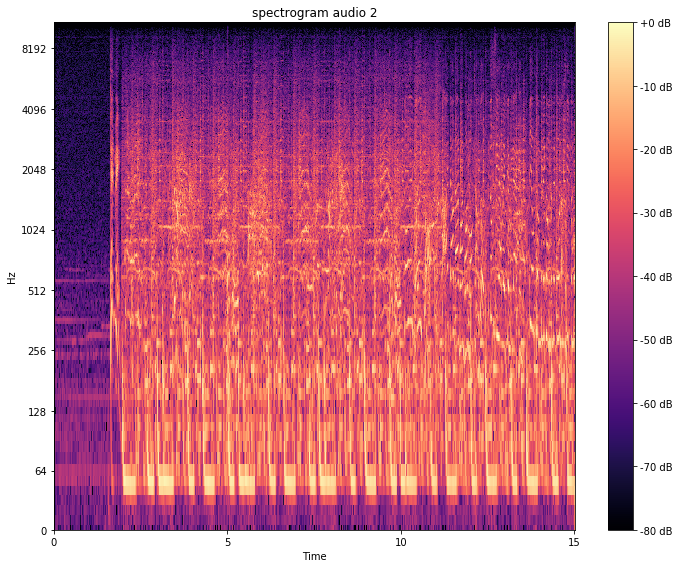

(2, 1025, 647)

In [243]:
# return magnitude S
def stft(signal):
    S, phase = librosa.magphase(np.abs(librosa.stft(signal, hop_length=1024)))
    return S

def plot_spect(index, S):
    plt.figure(figsize=(10, 8))
    librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='log', x_axis='time')
    title = "spectrogram audio {}".format(index+1)
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

signals_stft = []
for s in signals:
    signals_stft.append(stft(s))
    
signals_stft = np.asarray(signals_stft)


for index, s in enumerate(signals_stft):
    plot_spect(index, s)

signals_stft.shape

# 4. Features

# **4.1 Centróide**

(2, 647)

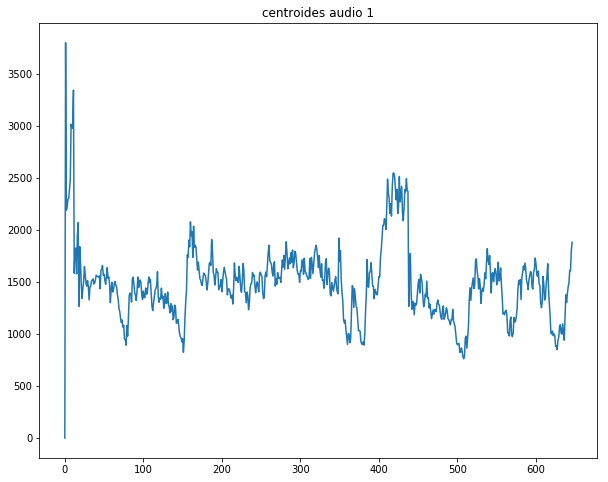

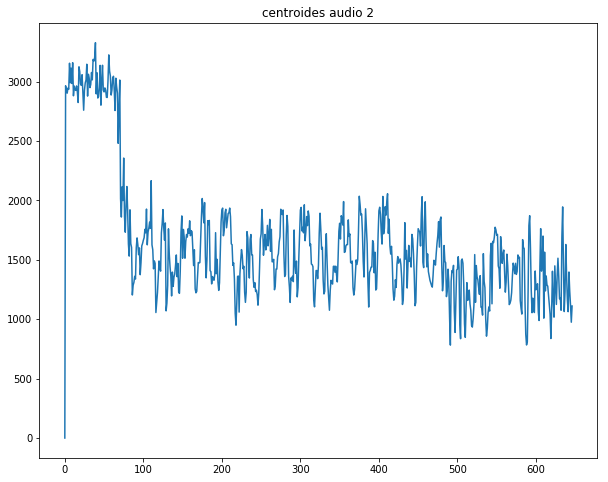

In [244]:
def get_centroid(S):
    return librosa.feature.spectral_centroid(S=S)

def plot_centroids(c, index):
    fig, a = plt.subplots(1, figsize = (10, 8))
    title = "centroides audio {}".format(index+1)
    plt.title(title)
    a.plot(c)

centroids = []
for s in signals_stft:
    c = get_centroid(s)
    centroids.append(c[0])
centroids = np.asarray(centroids)
    
for index, c in enumerate(centroids):
    plot_centroids(c, index)

centroids.shape


# 4.2 Flatness

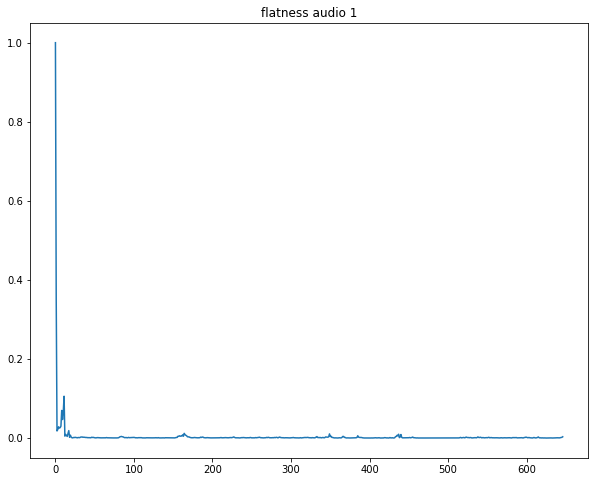

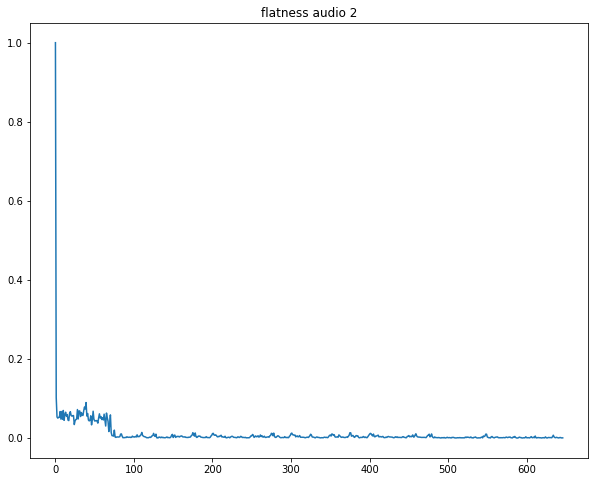

In [245]:
def get_flatness(S):
    return librosa.feature.spectral_flatness(S=S)

def plot_flatness(f, index):
    fig, a = plt.subplots(1, figsize = (10, 8))
    title = "flatness audio {}".format(index+1)
    plt.title(title)
    a.plot(f)
    

flatness = []
for s in signals_stft:
    f = get_flatness(s)
    flatness.append(f[0])
flatness = np.asarray(flatness)
    
for i, f in enumerate(flatness):
    plot_flatness(f, i)
    


(2, 20, 647)

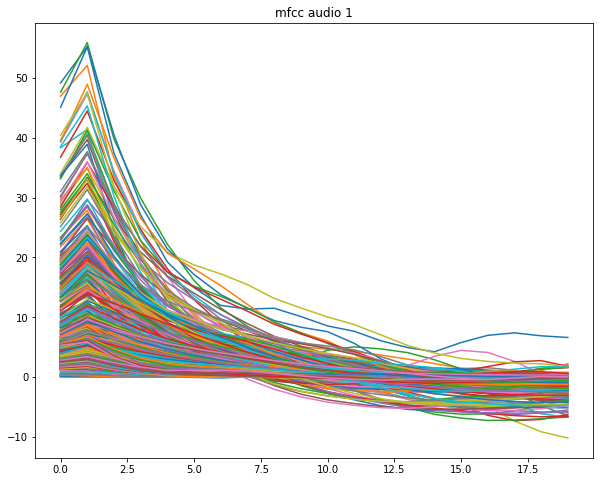

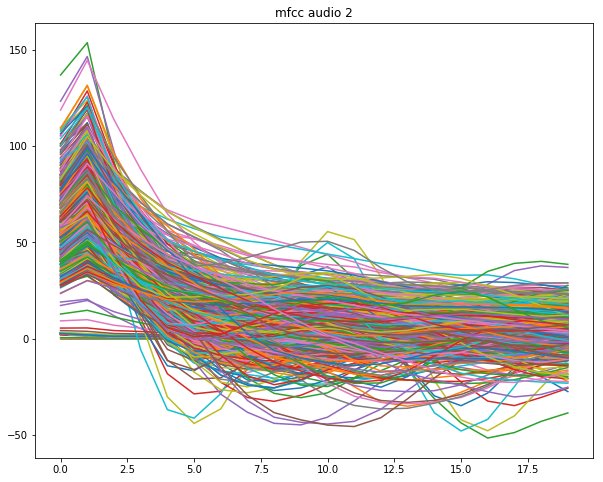

In [246]:
def get_mfcc(S):
    return librosa.feature.mfcc(S=S, hop_length=1024)

def plot_mfcc(m, index):
    fig, a = plt.subplots(1, figsize = (10, 8))
    title = "mfcc audio {}".format(index+1)
    plt.title(title)
    a.plot(m)
    

mfcc = []
for s in signals_stft:
    mfcc.append(get_mfcc(s))
mfcc = np.asarray(mfcc)
    
for i, m in enumerate(mfcc):
    plot_mfcc(m, i)
    
mfcc.shape

# 4.3 RMS

RMSe não está mais presente no librosa

[0.377, 1.897]


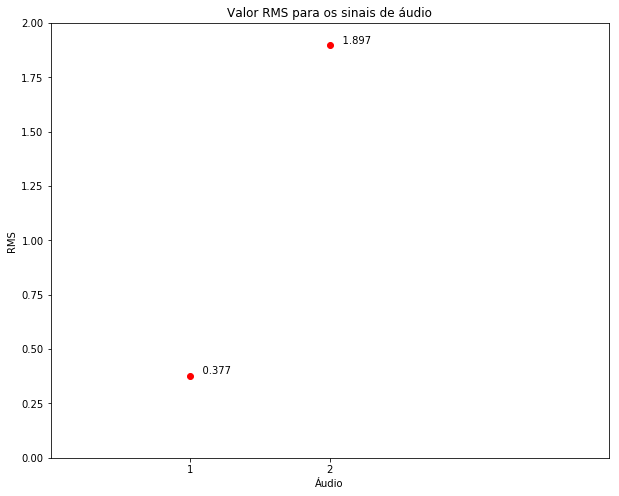

In [247]:
def get_rms(s):
    return librosa.feature.rms(s, hop_length=1024)

def plot_rms(x, y):
    print(y)
    fig, a = plt.subplots(1, figsize = (10, 8))
    a.axis([0, 4, 0, 2])
    a.plot(x, y, 'ro')
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.xlabel('Áudio')
    plt.ylabel('RMS')
    plt.title('Valor RMS para os sinais de áudio')
    for a,b in zip(x, y): 
        plt.text(a, b, '    ' + str(b), horizontalalignment='left', verticalalignment='bottom')
    
    
rms_arr = []
indexes = []
for i, s in enumerate(signals_stft):
    rms = get_rms(s)
    rms_arr.append(round(rms[0][0],3))
    indexes.append(i+1)
plot_rms(indexes, rms_arr)

In [197]:
import pandas as pd

In [198]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()

In [257]:
def generate_features_per_frame(centroids, flatness, mfcc, rms_arr, nframes, num_samples):
    dataframe_collection = {}
    for i in range(num_samples):
        dataframe_collection[i] = pd.DataFrame(np.vstack((centroids[i], flatness[i], mfcc[i], np.full((1, nframes), rms_arr[i]))))
        #feats = feats.rename(index={0: 'Centroid',1:'Flatness'})
        dataframe_collection[i] = dataframe_collection[i].T
        dataframe_collection[i]
    
    return dataframe_collection
    

In [258]:
feats = generate_features_per_frame(centroids, flatness, mfcc, rms_arr, 647, 2)
len(feats)

2

In [259]:
for i in range(len(feats)):
    for j in range(feats[i].shape[1]):
        feats[i].values[:,j] = scaler.fit_transform(feats[i].values)[:, j]
    feats[i]['Mean'] = np.mean(feats[i].values, axis=1)
    


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,Mean
0,-4.126591,23.714036,-0.972402,-0.973513,-0.960151,-0.928847,-0.911474,-0.918757,-0.918953,-0.904156,...,-0.023144,0.246479,0.414925,0.487465,0.547648,0.590577,0.619957,0.631727,0.0,0.575001
1,6.444177,8.233314,-0.972246,-0.973445,-0.960127,-0.928839,-0.911505,-0.918720,-0.918899,-0.904074,...,-0.023012,0.246680,0.415064,0.487517,0.547713,0.590630,0.619974,0.631705,0.0,0.361581
2,1.959887,0.335433,-0.954586,-0.959756,-0.946555,-0.911931,-0.892714,-0.893481,-0.890137,-0.867997,...,0.026163,0.294368,0.458321,0.525546,0.580544,0.623331,0.654953,0.667778,0.0,-0.147528
3,2.065430,0.428504,-0.950887,-0.956927,-0.944786,-0.909927,-0.889945,-0.891138,-0.887385,-0.865437,...,0.031705,0.300803,0.463299,0.530041,0.584932,0.627584,0.654460,0.663070,0.0,-0.136189
4,2.261942,0.584520,-0.949918,-0.956430,-0.944628,-0.910277,-0.892237,-0.893473,-0.890519,-0.868761,...,0.031217,0.297045,0.458220,0.528258,0.582392,0.625775,0.652198,0.663193,0.0,-0.122640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,0.020091,-0.081089,-0.316266,-0.323828,-0.348215,-0.379244,-0.410102,-0.430226,-0.448941,-0.489131,...,-0.330506,-0.279529,-0.306103,-0.316710,-0.261927,-0.158642,0.048348,0.204666,0.0,-0.287308
643,0.356980,-0.067647,-0.420662,-0.436295,-0.484955,-0.559054,-0.624278,-0.644521,-0.658308,-0.709302,...,-0.593357,-0.603910,-0.503627,-0.291073,-0.068711,0.178780,0.391063,0.523498,0.0,-0.344828
644,0.343830,-0.061080,-0.306414,-0.329906,-0.391893,-0.466017,-0.506413,-0.471578,-0.434086,-0.438515,...,0.189133,0.149343,0.006250,-0.084176,0.005165,0.204458,0.413903,0.557983,0.0,-0.127968
645,0.886187,-0.047394,-0.300997,-0.345841,-0.465300,-0.605759,-0.697666,-0.687322,-0.628607,-0.578058,...,-0.218665,-0.197158,-0.112020,0.004171,0.126525,0.299714,0.391536,0.448080,0.0,-0.201103


In [261]:
feats[1]

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,Mean
0,-3.070003,23.362338,-2.110987,-2.092784,-2.072861,-1.890109,-1.408694,-0.989746,-0.741729,-0.636063,...,-0.556993,-0.514348,-0.477023,-0.452439,-0.442337,-0.433331,-0.456313,-0.495313,0.0,0.095919
1,2.464104,2.174450,-2.110913,-2.092740,-2.072818,-1.890054,-1.408651,-0.989691,-0.741678,-0.636016,...,-0.556971,-0.514335,-0.477006,-0.452426,-0.442325,-0.433323,-0.456314,-0.495315,0.0,-0.584654
2,2.380089,1.019687,-2.092422,-2.081456,-2.062187,-1.874800,-1.394363,-0.974463,-0.728834,-0.621213,...,-0.548993,-0.507936,-0.473736,-0.449995,-0.440619,-0.432496,-0.457102,-0.497033,0.0,-0.630779
3,2.348481,0.951967,-2.040911,-2.049989,-2.031629,-1.830431,-1.354848,-0.929286,-0.692011,-0.580293,...,-0.517845,-0.478339,-0.443452,-0.431699,-0.424008,-0.417226,-0.448424,-0.483978,0.0,-0.608778
4,2.428617,0.990159,-2.013935,-2.034963,-2.017769,-1.804941,-1.332121,-0.903325,-0.666094,-0.553314,...,-0.495139,-0.457867,-0.423294,-0.416627,-0.409446,-0.405118,-0.434277,-0.476110,0.0,-0.586199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,-0.461358,-0.213461,-0.144603,-0.124277,-0.114669,-0.040161,0.304572,0.650098,0.727306,0.619617,...,1.016335,1.323027,1.772977,1.961805,1.681106,1.073672,0.480359,0.108700,0.0,0.622807
643,-0.764066,-0.206754,0.358051,0.460243,0.725705,1.031478,1.263572,1.321604,1.184497,0.897487,...,0.237279,0.497806,0.759693,0.840506,0.716869,0.546749,0.402001,0.259832,0.0,0.512160
644,-0.982046,-0.225966,-0.444474,-0.342911,-0.090313,0.232572,0.588492,0.786982,0.848633,0.838663,...,0.400369,0.520948,0.708097,0.810171,0.796713,0.727235,0.642233,0.555927,0.0,0.378406
645,-1.250242,-0.231587,-0.410967,-0.246932,0.135799,0.513531,0.817065,0.900349,0.818222,0.637197,...,-0.357232,-0.322077,-0.173193,-0.062990,-0.007374,0.052087,0.133934,0.249278,0.0,0.062353


In [201]:
import seaborn as sns

In [202]:
pca = PCA(1)
trans_pca = pca.fit_transform(feats.values)
print(pca.explained_variance_ratio_)

[0.60206168]


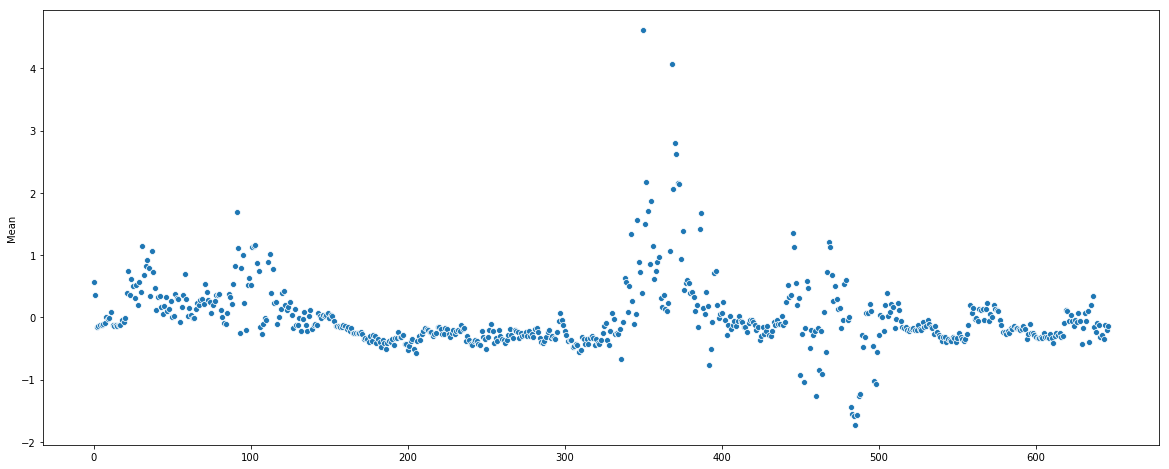

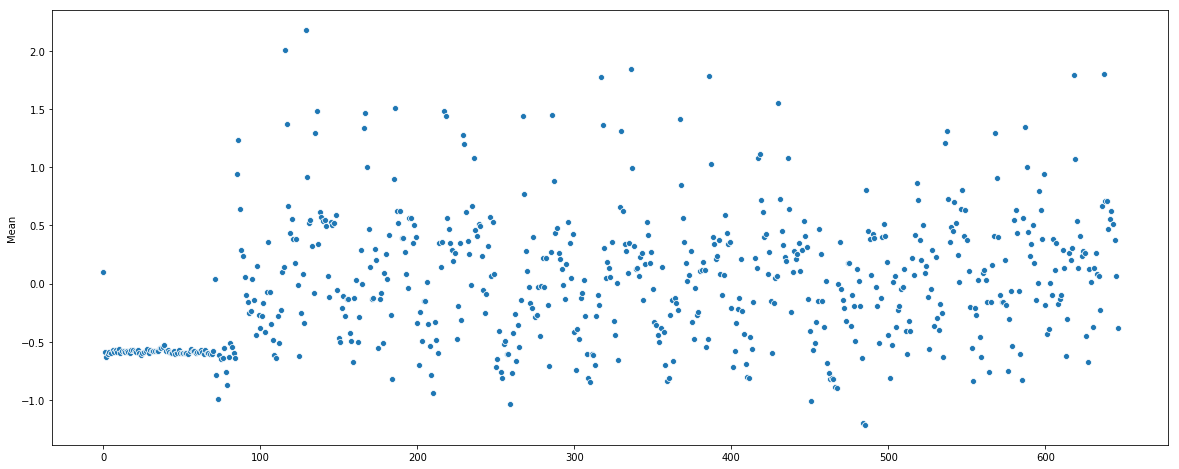

In [262]:
for i in range(len(feats)):
    plt.figure(figsize=(20,8))
    sns.scatterplot(x=feats[i].index, y=feats[i]['Mean'])


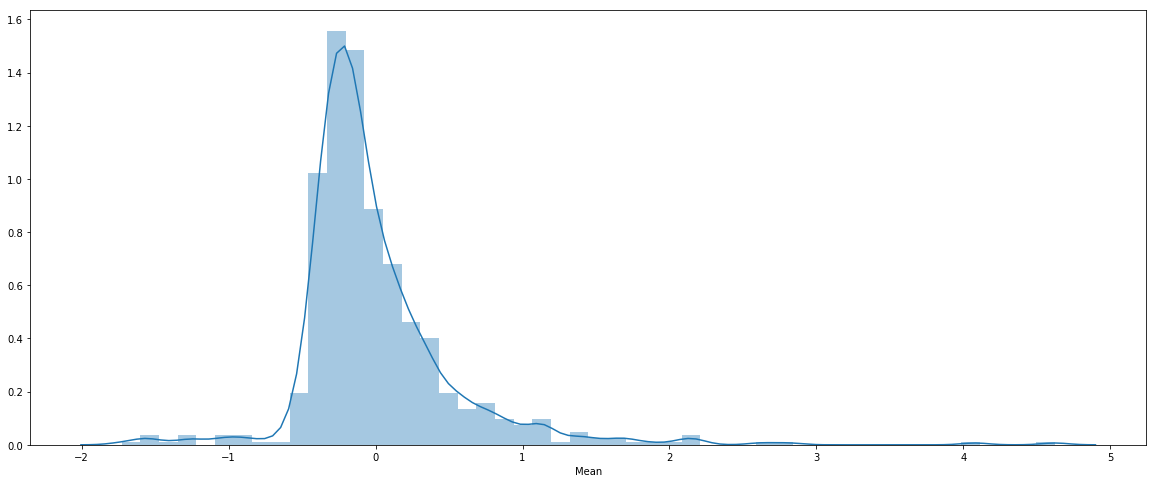

In [222]:
for i in range(len(feats)):
    plt.figure(figsize=(20,8))
    sns.distplot(feats[i]['Mean'])

In [204]:
info_signals = []
for c, f, r in zip(centroids, flatness, rms_arr):
    info_signals.append([np.mean(c), np.std(c), np.mean(f), np.std(f), r])

print(info_signals)

rotulos = np.array([0,1])
    

[[1482.5863708220538, 359.2762782028556, 0.0038395366, 0.04201937, 0.377]]


In [205]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(info_signals, rotulos)
y = knn.predict(info_signals)
print(y)

ValueError: Found input variables with inconsistent numbers of samples: [1, 2]